In [485]:
from sklearn import metrics
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interp
from itertools import cycle

from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split

# 5-classes case:

### Load data:

In [486]:
x = pd.read_csv('../Project_data/processed_data/x_post_preproc.csv', index_col='building_id')
y = pd.read_csv('../Project_data/processed_data/y_post_preproc.csv', index_col='building_id')

In [487]:
_, x_test = train_test_split(x, test_size=0.2, random_state=42)
y_test = y.loc[x_test.index]

In [488]:
classes = np.unique(y_test).tolist()

Load predictions:

In [490]:
clsfs = ['dummy', 'log', 'nn', 'rf', 'xgb']
train_sets = ['orig', 'smotenc', 'smotenc_tmk', 'smotenc_enn']

preds = {}

for clsf in clsfs:
    preds.update({clsf:{}})
    for train_set in train_sets:
        temp_data = pd.read_csv(f'results/{clsf}_preds_{train_set}.csv', index_col=0)
        
        if clsf == 'nn':
            predicted_class = pd.Series([f'Grade_{int(num)+1}' for num in temp_data.idxmax(1).values])
            temp_data = pd.concat([predicted_class, temp_data],1)
        
        temp_data.columns = ['pred'] + np.unique(temp_data.iloc[:,0]).tolist()
        preds[clsf].update({train_set: temp_data})

### F1 scores:

In [491]:
f1_scores = pd.DataFrame(columns = clsfs, index = train_sets)

for clsf in clsfs:
    for train_set in train_sets:
        f1_scores.loc[train_set, clsf] = metrics.f1_score(y_test, 
                                                          preds[clsf][train_set].iloc[:,0], 
                                                          average='micro')

In [492]:
f1_scores

,dummy,log,nn,rf,xgb
orig,0.199142,0.549492,0.571372,0.596724,0.592426
smotenc,0.199588,0.535314,0.575,0.586948,0.590576
smotenc_tmk,0.198092,0.53351,0.568925,0.584724,0.58969
smotenc_enn,0.200894,0.513742,0.544151,0.555029,0.55516


In [493]:
f1_scores.to_excel('f1scores.xlsx')

### ROC curves

Multi-class ROC:
   - https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html 
- but also:
   https://datascience.stackexchange.com/questions/77112/how-to-create-roc-auc-curves-for-multi-class-text-classification-problem-in-py

Average AUC:
   - https://waikato.github.io/weka-blog/posts/2019-02-16-micro_average/

In [ ]:
y_test_enc = label_binarize(y_test, classes)

In [218]:
# Compute ROC curve and ROC area for each class
n_cases = len(classes)+1
cases = classes + ["micro-avg"]

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_cases):
    case = cases[i]

    fpr.update({case: dict()})
    tpr.update({case: dict()})
    roc_auc.update({case: dict()})

    for clsf in clsfs[1:]: # skip dummy
        fpr[case].update({clsf: dict()})
        tpr[case].update({clsf: dict()})
        roc_auc[case].update({clsf: dict()})

        for train_set in train_sets:
            prediction = preds[clsf][train_set].iloc[:,1:]

            if case in classes:
                temp_fpr, temp_tpr, _ = metrics.roc_curve(y_test_enc[:, i], prediction.loc[:, case])
                temp_roc_auc = metrics.auc(temp_fpr, temp_tpr)

                fpr[case][clsf].update({train_set: temp_fpr})
                tpr[case][clsf].update({train_set: temp_tpr})
                roc_auc[case][clsf].update({train_set: temp_roc_auc})

            else:
                # Compute micro-average ROC curve and ROC area
                temp_fpr, temp_tpr, _ = metrics.roc_curve(y_test_enc.ravel(), prediction.values.ravel())
                temp_roc_auc = metrics.auc(temp_fpr, temp_tpr)

                fpr[case][clsf].update({train_set: temp_fpr})
                tpr[case][clsf].update({train_set: temp_tpr})
                roc_auc[case][clsf].update({train_set: temp_roc_auc})

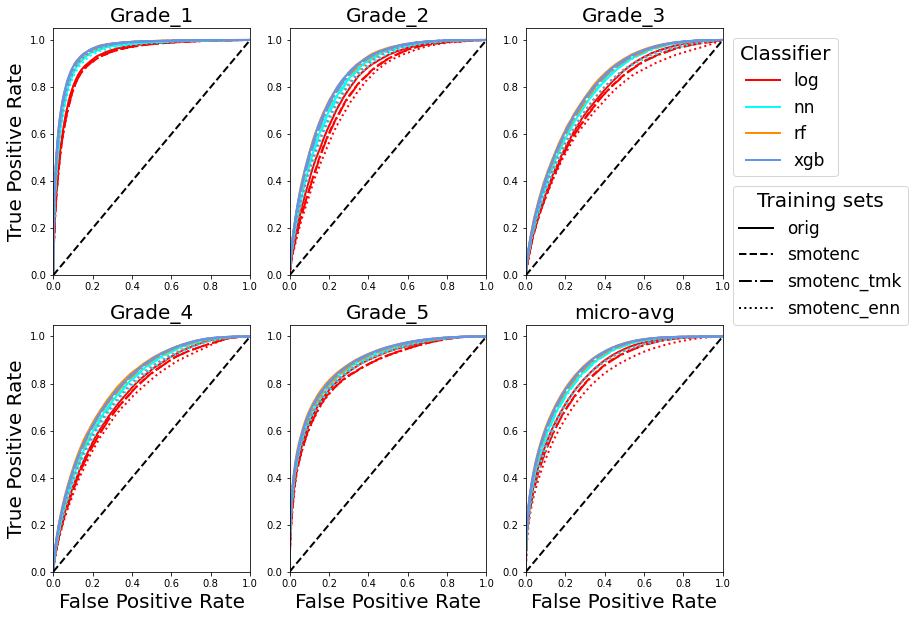

In [386]:
lw=2
fs=20
pos_case = dict(zip(cases, [(0,0), (0,1), (0,2), (1,0), (1,1), (1,2)]))
cols = dict(zip(clsfs[1:], ['red', 'aqua', 'darkorange', 'cornflowerblue']))
l_styles = dict(zip(train_sets, ['-', '--', '-.', ':']))

fig, ax = plt.subplots(2,3, figsize=(12,10))

for case in cases:
    row,col = pos_case[case]

    for clsf in clsfs[1:]: # skip dummy
        for train_set in train_sets:
            ax[row,col].plot(fpr[case][clsf][train_set], tpr[case][clsf][train_set], 
                             color=cols[clsf], linestyle=l_styles[train_set], linewidth=lw) 

    ax[row,col].plot([0, 1], [0, 1], 'k--', lw=lw)
    ax[row,col].set_title(f'{case}', fontsize=fs)
    
    ax[row,col].set_xlim([0.0, 1.0])
    ax[row,col].set_ylim([0.0, 1.05])

    if col == 0:
        ax[row,col].set_ylabel('True Positive Rate', fontsize=fs)
    
    if row == 1:
        ax[row,col].set_xlabel('False Positive Rate', fontsize=fs)

        
lines_col = [Line2D([0], [0], color=c, linewidth=lw) for c in cols.values()]
lines_style = lines = [Line2D([0], [0], linewidth=lw, linestyle=style, c='k') for style in l_styles.values()]

leg_col = plt.legend(lines_col, list(cols), loc=(1.05, 1.6), title='Classifier', title_fontsize=fs, fontsize=fs-3)
plt.legend(lines_style, list(l_styles), loc=(1.05, 1.), title='Training sets', title_fontsize=fs, fontsize=fs-3)

plt.gca().add_artist(leg_col)

#fig.suptitle('ROC curves for each class for all classifiers and training sets', fontsize=fs+10)

#plt.savefig('results/figs/ROCs.png', bbox_inches='tight')

In [315]:
auc_df = pd.DataFrame(columns=['class', 'classifier', 'training_set', 'AUC'])

for case in cases:
    for clsf in clsfs[1:]: # skip dummy
        for train_set in train_sets:
            temp_auc = pd.DataFrame([case, clsf, train_set, roc_auc[case][clsf][train_set]], index=auc_df.columns).T
            auc_df = pd.concat([auc_df, temp_auc])
auc_df.reset_index(drop=True)

,class,classifier,training_set,AUC
0,Grade_1,log,orig,0.930264
1,Grade_1,log,smotenc,0.924945
2,Grade_1,log,smotenc_tmk,0.925194
3,Grade_1,log,smotenc_enn,0.926955
4,Grade_1,nn,orig,0.947587
...,...,...,...,...
91,micro-avg,rf,smotenc_enn,0.849051
92,micro-avg,xgb,orig,0.879272
93,micro-avg,xgb,smotenc,0.878322
94,micro-avg,xgb,smotenc_tmk,0.87704


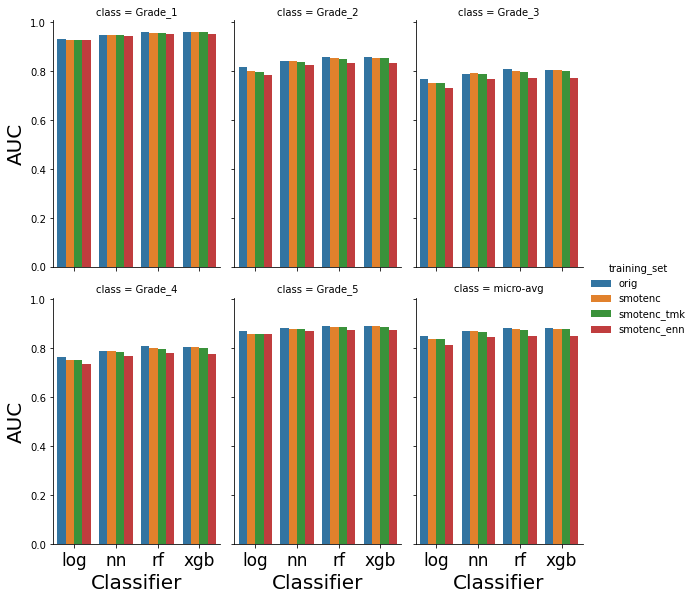

In [373]:
cat = sns.catplot(data=auc_df, x='classifier', y='AUC', 
                  hue='training_set', col='class', kind='bar', col_wrap=3, height=4, aspect=1/1.5)

cat.set_ylabels(fontsize=fs)
cat.set_xlabels('Classifier',fontsize=fs)
cat.set_xticklabels(fontsize=fs-3)

#plt.savefig('results/figs/AUC.png', bbox_inches='tight')

Micro-F1 is **the same** as accuracy in problems where each instance is assigned one (and only one) class
    https://simonhessner.de/why-are-precision-recall-and-f1-score-equal-when-using-micro-averaging-in-a-multi-class-problem/

- accuracy is the average of the f1 scores
- macro avg is the average between the unweighted precision and recall averages
- weighted avg is the average between the (support)-weighted precision and recall averages

support is the number of instances in each class

# 3-classes case:

### Load data:

In [414]:
x = pd.read_csv('../Project_data/processed_data/x_post_preproc.csv', index_col='building_id')
y = pd.read_csv('../Project_data/processed_data/y_post_preproc_3lab.csv', index_col='building_id')

In [415]:
_, x_test = train_test_split(x, test_size=0.2, random_state=42)
y_test = y.loc[x_test.index]

In [416]:
classes = np.unique(y_test).tolist()

Load predictions:

In [449]:
clsfs = ['dummy', 'log', 'nn', 'rf', 'xgb']

preds = {}

for clsf in clsfs:
    temp_data = pd.read_csv(f'results/{clsf}_preds_3cls.csv', index_col=0)
        
    if clsf == 'nn':
        predicted_class = pd.Series([f'G{int(num)+1}' for num in temp_data.idxmax(1).values])
        temp_data = pd.concat([predicted_class, temp_data],1)

    temp_data.columns = ['pred'] + np.unique(temp_data.iloc[:,0]).tolist()
    preds.update({clsf: temp_data})

### F1 scores:

In [458]:
f1_scores = pd.DataFrame(columns = clsfs, index=['3Classes'])

for clsf in clsfs:
    f1_scores.loc[:,clsf] = metrics.f1_score(y_test, preds[clsf].iloc[:,0], average='micro')

In [459]:
f1_scores

,dummy,log,nn,rf,xgb
3Classes,0.335654,0.685708,0.70505,0.722449,0.720068


In [467]:
f1_scores.to_excel('f1scores_3labs.xlsx')

### ROC curves

Multi-class ROC:
   - https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html 
- but also:
   https://datascience.stackexchange.com/questions/77112/how-to-create-roc-auc-curves-for-multi-class-text-classification-problem-in-py

Average AUC:
   - https://waikato.github.io/weka-blog/posts/2019-02-16-micro_average/

In [420]:
y_test_enc = label_binarize(y_test, classes=classes)

In [468]:
# Compute ROC curve and ROC area for each class
n_cases = len(classes)+1
cases = classes + ["micro-avg"]

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_cases):
    case = cases[i]

    fpr.update({case: dict()})
    tpr.update({case: dict()})
    roc_auc.update({case: dict()})

    for clsf in clsfs[1:]: # skip dummy
        prediction = preds[clsf].iloc[:,1:]

        fpr[case].update({clsf: dict()})
        tpr[case].update({clsf: dict()})
        roc_auc[case].update({clsf: dict()})

        if case in classes:
            temp_fpr, temp_tpr, _ = metrics.roc_curve(y_test_enc[:, i], prediction.loc[:, case])
            temp_roc_auc = metrics.auc(temp_fpr, temp_tpr)

            fpr[case].update({clsf: temp_fpr})
            tpr[case].update({clsf: temp_tpr})
            roc_auc[case].update({clsf: temp_roc_auc})

        else:
            # Compute micro-average ROC curve and ROC area
            temp_fpr, temp_tpr, _ = metrics.roc_curve(y_test_enc.ravel(), prediction.values.ravel())
            temp_roc_auc = metrics.auc(temp_fpr, temp_tpr)

            fpr[case].update({clsf: temp_fpr})
            tpr[case].update({clsf: temp_tpr})
            roc_auc[case].update({clsf: temp_roc_auc})

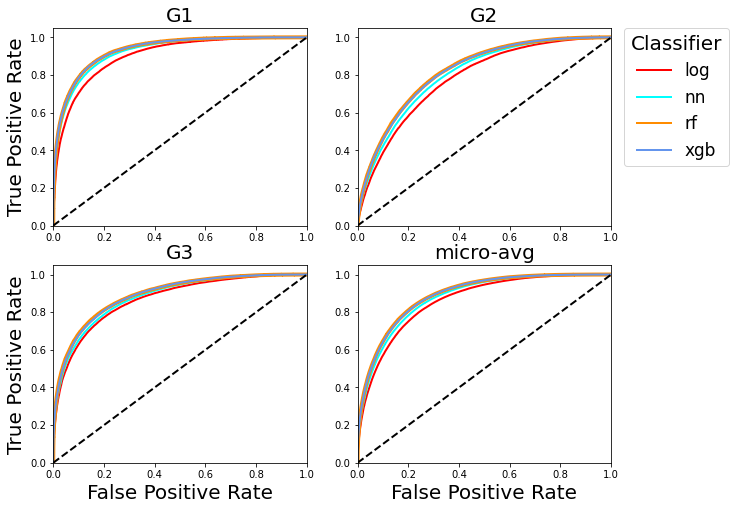

In [480]:
fs=20
pos_case = dict(zip(cases, [(0,0), (0,1), (1,0), (1,1)]))
cols = dict(zip(clsfs[1:], ['red', 'aqua', 'darkorange', 'cornflowerblue']))

fig, ax = plt.subplots(2,2, figsize=(10,8))

for case in cases:
    row, col = pos_case[case]

    for clsf in clsfs[1:]: # skip dummy
        lw=2

        if clsf == 'rf':
            lw=4
        ax[row,col].plot(fpr[case][clsf], tpr[case][clsf], 
                         color=cols[clsf], linewidth=lw) 

    ax[row,col].plot([0,1], [0,1], 'k--', lw=lw)
    ax[row,col].set_title(f'{case}', fontsize=fs)
    
    ax[row,col].set_xlim([0.0, 1.0])
    ax[row,col].set_ylim([0.0, 1.05])

    if col == 0:
        ax[row,col].set_ylabel('True Positive Rate', fontsize=fs)
    
    if row == 1:
        ax[row,col].set_xlabel('False Positive Rate', fontsize=fs)

lines_col = [Line2D([0], [0], color=c, linewidth=lw) for c in cols.values()]

plt.legend(lines_col, list(cols), loc=(1.05, 1.5), title='Classifier', title_fontsize=fs, fontsize=fs-3)

#plt.savefig('results/figs/ROCs_3cls.png', bbox_inches='tight')

In [474]:
auc_df = pd.DataFrame(columns=['class', 'classifier', 'AUC'])

for case in cases:
    for clsf in clsfs[1:]: # skip dummy
        temp_auc = pd.DataFrame([case, clsf, roc_auc[case][clsf]], index=auc_df.columns).T
        auc_df = pd.concat([auc_df, temp_auc])
auc_df.reset_index(drop=True)

,class,classifier,AUC
0,G1,log,0.901616
1,G1,nn,0.922157
2,G1,rf,0.931515
3,G1,xgb,0.931363
4,G2,log,0.779798
5,G2,nn,0.801703
6,G2,rf,0.820211
7,G2,xgb,0.818523
8,G3,log,0.867338
9,G3,nn,0.878436


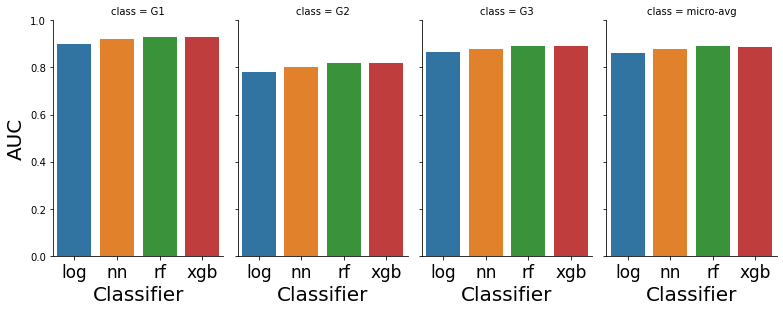

In [484]:
cat = sns.catplot(data=auc_df, x='classifier', y='AUC', col='class', kind='bar', col_wrap=4, height=4, aspect=1/1.5)

cat.set(ylim=(0,1))
cat.set_ylabels(fontsize=fs)
cat.set_xlabels('Classifier',fontsize=fs)
cat.set_xticklabels(fontsize=fs-3)

#plt.savefig('results/figs/AUC_3cls.png', bbox_inches='tight')